In [ ]:
"""
Reviewed on 20190204

@author: SK.Lin
@review: Ross.Lee

Dataset shape: (143, 2)
    First column: Date (by week)
    Second column: 每週出貨量
目標: 抓X的8週數據，預測Y的數據。必須考慮Lead Time 8週。
說明(以數據維度來看):
   取X 0-7 -> 預測Y 15 (X[0:8] = 0-7)
   取X 1-8 -> 預測Y 16
   ...
   取X 129-136 -> 預測Y 144 (共144筆)
   
*是一個many to one的RNN問題

Demo兩種做法:
    Approach1: 把X, Y切好 -> 寫get_batch function並把SHIFT放進去 -> 寫預測function預測
    Approach2: 把X, Y直接做成pair -> 寫get_batch_data隨機打亂產生批量資料 -> 預測
"""

# Import

In [170]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM, LeakyReLU, BatchNormalization
from keras.models import Sequential
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

# Read the data

In [266]:
lead_time_data = pd.read_csv('week.csv', names=['Date', 'Counts'])
lead_time_data.head(10)

,Date,Counts
0,2015-04-06,0.0
1,2015-04-13,0.0
2,2015-04-20,0.0
3,2015-04-27,0.0
4,2015-05-04,0.0
5,2015-05-11,0.0
6,2015-05-18,0.0
7,2015-05-25,0.0
8,2015-06-01,0.0
9,2015-06-08,0.0


# Approach 1

## Data Preparation

In [148]:
"""
Lead time為8周，所以x從第1周開始；y從第16周開始
"""

X = lead_time_data.Counts[:-8]  # 136 --> X每次取8週的資料，預測8週後的Y
Y = lead_time_data.Counts[15:]  # 129 --> 預測第16周為第一筆 (從LeadTime 8週 & 8週的X 出發)

X = np.asarray(X).reshape((-1, 1))
Y = np.asarray(Y).reshape((-1, 1))

# 取X 0-7 -> 預測Y 15
# 取X 1-8 -> 預測Y 16
# ...
# 取X 129-136 -> 預測Y 144 共144筆

print("lead_time_data shape", lead_time_data.shape)
print("shape of X", X.shape)
print("shape of Y", Y.shape)

# 訓練資料為80%的資料
X_train = X[:int(X.shape[0] * 0.8)]  # 0:108 最後一個是(100~108)==100到107筆 100+8+8-1=115
# 這裡最關鍵!! 下一個window從101開始(X的136是upper bound，在產生batch的時候是
# 101:101+8預測101+8+8-1=116, 102:102+8, ..., 129:129+8(到136)預測129+8+8-1=144 
# 因此，X是往上加的，在產生批量的時候136會再往後減掉一個TimeStep=8週，導致X_test是35筆
# 但其實算有效的X跟Y的筆數的時候，都一樣是129
X_test = X[int(X.shape[0] * 0.8 - 7):]  # 101:136
# Y train: 15:116 -> 0:101
# Y test: 116:144 -> 101:129
Y_train = Y[0:101]
Y_test = Y[101:129]

# X跟Y會差7週
print("shape of X_train", X_train.shape)
print("shape of X_test", X_test.shape)
print("shape of Y_train", Y_train.shape)
print("shape of Y_test", Y_test.shape)

lead_time_data shape (144, 2)
shape of X (136, 1)
shape of Y (129, 1)
shape of X_train (108, 1)
shape of X_test (35, 1)
shape of Y_train (101, 1)
shape of Y_test (28, 1)


In [149]:
# 進行scale的動作
X_scale = MinMaxScaler(feature_range=(0, 100))
x_train = X_scale.fit_transform(X_train)
Y_scale = MinMaxScaler(feature_range=(0, 100))
y_train = Y_scale.fit_transform(Y_train)

## get batch

In [267]:
#SHIFT是在產生Batch的時候加進去

def get_batch(data_x, data_y, batch_size, time_step):
    while True:
        # [samples, time steps, features]
        x_batch = np.zeros(shape=[batch_size, time_step, 1], dtype=np.float32)
        y_batch = np.zeros(shape=[batch_size, 1], dtype=np.float32)

        # 隨機從資料中生成batch_size筆的x_batch和y_batch
        for i in range(batch_size):
            index = np.random.randint(len(data_y))

            x_batch[i] = data_x[index: index + SHIFT].reshape([SHIFT, 1])
            y_batch[i] = data_y[index].reshape([1])  # 已經進行過SHIFT

        yield (x_batch, y_batch)

# parameter settings
SHIFT = 8
BATCH = 128

generator = get_batch(x_train, y_train, BATCH, SHIFT) # 一個batch 8天(8筆資料)
# 可以看下一圈
m, n = next(generator)
print("X_batch shape", m.shape)
print("Y_batch shape", n.shape)

X_batch shape (128, 8, 1)
Y_batch shape (128, 1)


## construct the model

In [151]:
model = Sequential()
model.add(LSTM(input_shape=(None, 1), units=30, return_sequences=False, activation='relu'))
model.add(Dense(units=1))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.summary()
model.compile(optimizer='RMSProp', loss='mse', metrics=['mape'])
# callback = TensorBoard(batch_size=BATCH)
history = model.fit_generator(generator=generator, steps_per_epoch=256, epochs=150)  # , callbacks=[callback])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
_________________________________________________________________
batch_normalization_4 (Batch (None, 1)                 4         
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1)                 0         
Total params: 3,875
Trainable params: 3,873
Non-trainable params: 2
_________________________________________________________________
Epoch 1/150
256/256 [==============================] - 2s 9ms/step - loss: 2892.6459 - mean_absolute_percentage_error: 4893962.6639
Epoch 2/150
256/256 [==============================] - 1s 6ms/step - loss: 2839.4396 - mean_absolute_percentage_error: 5083074.1655
Epoch 3/

256/256 [==============================] - 1s 5ms/step - loss: 331.6555 - mean_absolute_percentage_error: 147069129.2232
Epoch 117/150
256/256 [==============================] - 1s 6ms/step - loss: 321.3705 - mean_absolute_percentage_error: 161148542.7578
Epoch 118/150
256/256 [==============================] - 1s 5ms/step - loss: 312.3494 - mean_absolute_percentage_error: 180437855.3270
Epoch 119/150
256/256 [==============================] - 1s 5ms/step - loss: 309.0839 - mean_absolute_percentage_error: 171278106.0366
Epoch 120/150
256/256 [==============================] - 1s 5ms/step - loss: 302.0815 - mean_absolute_percentage_error: 170101881.2927
Epoch 121/150
256/256 [==============================] - 1s 5ms/step - loss: 292.3529 - mean_absolute_percentage_error: 171696009.7027
Epoch 122/150
256/256 [==============================] - 1s 5ms/step - loss: 279.7816 - mean_absolute_percentage_error: 166033854.9133
Epoch 123/150
256/256 [==============================] - 1s 6ms/step 

## predicct

In [157]:
def make_pred_data(input_data, step_time):
    data4pred = np.zeros(shape=(input_data.shape[0] - step_time + 1, step_time, 1))
    for i in range(input_data.shape[0] - step_time + 1):
        data4pred[i] = input_data[i:i + step_time]
    return data4pred

In [243]:
test_scale = MinMaxScaler(feature_range=(0, 100))
x_test = test_scale.fit_transform(X_test)
x_2_test = make_pred_data(x_test, SHIFT)  # SHIFT可看成LeadTeam，x_tset本身已經有扣掉TimeStep(136)
pred = model.predict(x_2_test)
pred_inverse = test_scale.inverse_transform(pred)  # 轉回原始數據

## Visualization

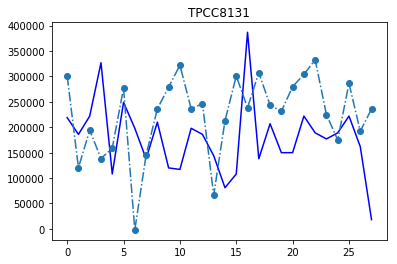

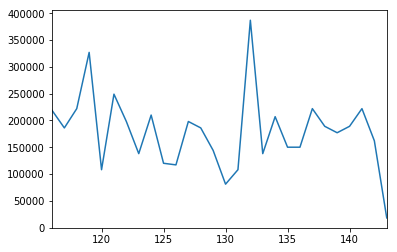

In [167]:
plt.plot(Y_test, 'b-')
plt.plot(pred_inverse, 'o-.')
# plt.legend()
plt.title('TPCC8131')
plt.show()
# lead_time_data.Counts[-28:].plot()

# Approach 2
`一開始就把pair資料做好`

## Functions

In [319]:
def buildTrain(data, pastDay=8, LeadTime=8, futureDay=1):
    X_train, Y_train = [], []
    for i in range(data.shape[0] - pastDay - LeadTime + 1):
        X_train.append(data[i:i+pastDay])  # pastDay筆
        Y_train.append(data[(i+pastDay+LeadTime-1):(i+pastDay+LeadTime+futureDay-1)])
    return np.array(X_train), np.array(Y_train)


def splitData(X, Y, rate):
    X_train = X[:int(X.shape[0] * rate)]
    Y_train = Y[:int(Y.shape[0] * rate)]
    X_val = X[int(X.shape[0] * rate):]
    Y_val = Y[int(Y.shape[0] * rate):]
    return X_train, Y_train, X_val, Y_val


def rescale(data):
    data_scaler = MinMaxScaler(feature_range=(0, 100))
    scaled_data = data_scaler.fit_transform(data)
    return data_scaler, scaled_data


def turn_data2test(x_data, TimeStep=None, LeadTime=8):
    """
    input: data shape is one-dim array
        e.g. (28,)
    製作一批一批的測試資料
    """
    test_data = np.zeros(shape=(x_data.shape[0] - TimeStep - LeadTime + 1, TimeStep))
    for i in range(x_data.shape[0] - TimeStep - LeadTime + 1):
        test_data[i] = x_data[i:(i+TimeStep)]
    _, test_data = rescale(test_data)  # 趁還沒+維度趕緊rescale
    return np.expand_dims(test_data, axis=2)  # feature = 1
    # example: turn_data2test(x_data=lead_time_data["Counts"][-28:], TimeStep=8)
    # shape: (21, 8, 1) <-> (batches, timestep, features)

## Data Preparation

In [285]:
X2, Y2 = buildTrain(data=lead_time_data["Counts"].values)
X2_train, Y2_train, X2_test, Y2_test = splitData(X=X2, Y=Y2, rate=0.8)

_, X2_train = rescale(X2_train)
_, Y2_train = rescale(Y2_train)

_, X2_test = rescale(X2_test) 
Y2_test_scaler, Y2_test = rescale(Y2_test)  # 留著scale物件等等要用

X2_train = np.expand_dims(X2_train, axis=2)
X2_val = np.expand_dims(X2_val, axis=2)

## Get random batch

In [225]:
def generate_batch_data_random(x, y, batch_size, TimeStep=8):
    data_nums = x.shape[0]
    while (True):
        x_batch = np.zeros(shape=(batch_size, TimeStep, 1))  # Feature number = 1
        y_batch = np.zeros(shape=(batch_size, 1))
        
        for i in range(batch_size):
            idx = np.random.randint(low=0, high=data_nums)
            x_batch[i] = x[idx]
            y_batch[i] = y[idx]
        
        yield x_batch, y_batch
        
generator = generate_batch_data_random(x=X2_train, y=Y2_train, batch_size=128)

In [226]:
model = Sequential()
model.add(LSTM(30, input_shape=(s[1], s[2]),
               return_sequences=False, activation='relu'))
model.add(Dense(1))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.summary()
model.compile(optimizer='RMSProp', loss='mse', metrics=['mape'])
# callback = TensorBoard(batch_size=BATCH)
# history = model.fit_generator(generator=generator, steps_per_epoch=256, epochs=150)  # , callbacks=[callback])
earlystopping = EarlyStopping(
    monitor="loss", patience=10, verbose=1, mode="auto")
# reducelr = ReduceLROnPlateau(
#     monitor='val_loss', factor=0.5, patience=5, min_lr=0.001)
csvlog = CSVLogger('myweek_log')

model.fit_generator(generator=generator, steps_per_epoch=128, epochs=1000,
                    callbacks=[earlystopping, csvlog])

# model.fit_generator(generator=generator, steps_per_epoch=128, epochs=1000,
#                     callbacks=[earlystopping, reducelr, csvlog])
# validation_data=(X2_val, Y2_val)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 30)                3840      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 31        
_________________________________________________________________
batch_normalization_16 (Batc (None, 1)                 4         
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 1)                 0         
Total params: 3,875
Trainable params: 3,873
Non-trainable params: 2
_________________________________________________________________
Epoch 1/1000
128/128 [==============================] - 3s 21ms/step - loss: 2622.5025 - mean_absolute_percentage_error: 1240654.0260
Epoch 2/1000
 31/128 [======>.......................] - ETA: 0s - loss: 2636.2282 - mean_absolute_percentage_error: 2414086.7115

/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_percentage_error,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


128/128 [==============================] - 1s 5ms/step - loss: 2595.3560 - mean_absolute_percentage_error: 3876697.0289
Epoch 3/1000
128/128 [==============================] - 1s 6ms/step - loss: 2592.8348 - mean_absolute_percentage_error: 5144822.5352
Epoch 4/1000
128/128 [==============================] - 1s 6ms/step - loss: 2571.1394 - mean_absolute_percentage_error: 5550128.0502
Epoch 5/1000
128/128 [==============================] - 1s 6ms/step - loss: 2553.2768 - mean_absolute_percentage_error: 5014359.6477
Epoch 6/1000
128/128 [==============================] - 1s 6ms/step - loss: 2516.0511 - mean_absolute_percentage_error: 6052489.7827
Epoch 7/1000
128/128 [==============================] - 1s 6ms/step - loss: 2522.6527 - mean_absolute_percentage_error: 5470508.3666
Epoch 8/1000
128/128 [==============================] - 1s 6ms/step - loss: 2486.4771 - mean_absolute_percentage_error: 4608896.8782
Epoch 9/1000
128/128 [==============================] - 1s 6ms/step - loss: 2490.6

128/128 [==============================] - 1s 6ms/step - loss: 1643.3786 - mean_absolute_percentage_error: 21328269.6563
Epoch 64/1000
128/128 [==============================] - 1s 6ms/step - loss: 1637.3963 - mean_absolute_percentage_error: 17384219.0803
Epoch 65/1000
128/128 [==============================] - 1s 6ms/step - loss: 1615.7301 - mean_absolute_percentage_error: 15905102.7880
Epoch 66/1000
128/128 [==============================] - 1s 6ms/step - loss: 1594.2450 - mean_absolute_percentage_error: 22723731.7059
Epoch 67/1000
128/128 [==============================] - 1s 5ms/step - loss: 1602.6203 - mean_absolute_percentage_error: 22587968.5120
Epoch 68/1000
128/128 [==============================] - 1s 6ms/step - loss: 1587.5982 - mean_absolute_percentage_error: 19271415.8828
Epoch 69/1000
128/128 [==============================] - 1s 5ms/step - loss: 1563.4134 - mean_absolute_percentage_error: 16222858.2040
Epoch 70/1000
128/128 [==============================] - 1s 6ms/step 

128/128 [==============================] - 1s 5ms/step - loss: 454.2893 - mean_absolute_percentage_error: 78097322.4366
Epoch 184/1000
128/128 [==============================] - 1s 6ms/step - loss: 459.8398 - mean_absolute_percentage_error: 85463795.5254
Epoch 185/1000
128/128 [==============================] - 1s 6ms/step - loss: 444.0959 - mean_absolute_percentage_error: 81813247.1315
Epoch 186/1000
128/128 [==============================] - 1s 5ms/step - loss: 444.4436 - mean_absolute_percentage_error: 90301171.0660
Epoch 187/1000
128/128 [==============================] - 1s 6ms/step - loss: 455.6620 - mean_absolute_percentage_error: 87313058.0753
Epoch 188/1000
128/128 [==============================] - 1s 6ms/step - loss: 438.8328 - mean_absolute_percentage_error: 72069579.4097
Epoch 189/1000
128/128 [==============================] - 1s 6ms/step - loss: 439.5239 - mean_absolute_percentage_error: 96850793.8392
Epoch 190/1000
128/128 [==============================] - 1s 6ms/step 

128/128 [==============================] - 1s 6ms/step - loss: 92.2944 - mean_absolute_percentage_error: 191539794.4949
Epoch 304/1000
128/128 [==============================] - 1s 6ms/step - loss: 87.0036 - mean_absolute_percentage_error: 165858297.1745
Epoch 305/1000
128/128 [==============================] - 1s 6ms/step - loss: 88.3972 - mean_absolute_percentage_error: 174377521.3024
Epoch 306/1000
128/128 [==============================] - 1s 6ms/step - loss: 86.7281 - mean_absolute_percentage_error: 174376671.5106
Epoch 307/1000
128/128 [==============================] - 1s 5ms/step - loss: 82.6326 - mean_absolute_percentage_error: 168466276.5263
Epoch 308/1000
128/128 [==============================] - 1s 5ms/step - loss: 83.7283 - mean_absolute_percentage_error: 164148593.2284
Epoch 309/1000
128/128 [==============================] - 1s 6ms/step - loss: 83.6981 - mean_absolute_percentage_error: 158307906.0685
Epoch 310/1000
128/128 [==============================] - 1s 5ms/step 

## Predict

In [287]:
pred = model.predict(X2_val)  # predict完的還是MinMaxScale的結果
pred_inverse = Y2_test_scaler.inverse_transform(pred)  # 轉回原始數據
pred_inverse

array([[198580.3 ],
       [222943.94],
       [234580.86],
       [176650.4 ],
       [211978.45],
       [143542.05],
       [189268.1 ],
       [196859.98],
       [189732.84],
       [116601.63],
       [216171.3 ],
       [141070.92],
       [154206.62]], dtype=float32)

## Visualization

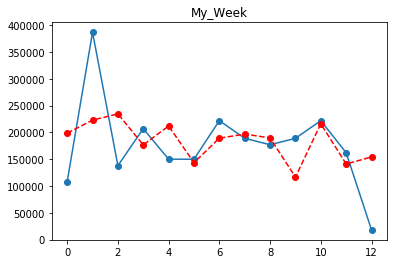

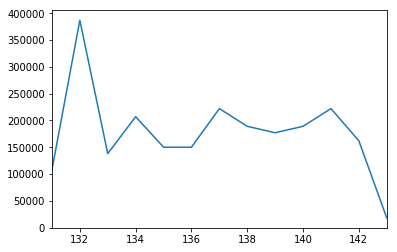

In [297]:
plt.plot(Y2_val, 'o-')
plt.plot(pred_inverse, 'or--')
# plt.legend()
plt.title('My_Week')
plt.show()
lead_time_data.Counts[-13:].plot()

## Use turn_date2test function

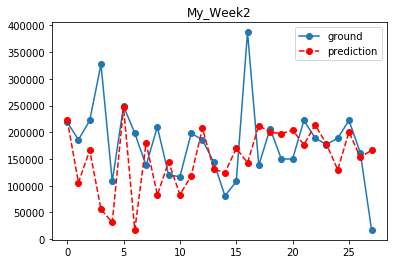

In [322]:
# 預測y的 116-144
X3_test = turn_data2test(x_data=lead_time_data["Counts"][101:144], TimeStep=8, LeadTime=8)  

pred2 = model.predict(X3_test)
pred_inverse2 = Y2_test_scaler.inverse_transform(pred2)  # 轉回原始數據

plt.plot(lead_time_data["Counts"][116:144].values, 'o-', label="ground")
plt.plot(pred_inverse2, 'or--', label="prediction")
plt.legend(loc="upper right")
plt.title('My_Week2')
plt.show()